# Week 7 Notebook: Model training, hyperparameter tuning, and model evaluation
The goal of this week's assignment is to use a second modeling method with 3 different hyperparameter settings of the method. 

### Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
# from sklearn.model_selection import cross_val_score


### Read data as dataframe

In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

data_folder = os.path.join(parent_dir,"data")
raw_data_folder = os.path.join(data_folder,"raw")
interim_data_folder = os.path.join(data_folder,"interim")
processed_data_folder = os.path.join(data_folder, "processed")

In [3]:
# Save PCA DataFrames as Parquet files
X_train_scaled_path = os.path.join(processed_data_folder, 'X_train_scaled.parquet')
X_val_scaled_path = os.path.join(processed_data_folder, 'X_val_scaled.parquet')
X_test_scaled_path = os.path.join(processed_data_folder, 'X_test_scaled.parquet')

# Paths for the target variables
y_train_path = os.path.join(processed_data_folder, 'y_train.parquet')
y_val_path = os.path.join(processed_data_folder, 'y_val.parquet')
y_test_path = os.path.join(processed_data_folder, 'y_test.parquet')

train_pca_path = os.path.join(processed_data_folder, 'X_train_pca.parquet')
val_pca_path = os.path.join(processed_data_folder, 'X_val_pca.parquet')
test_pca_path = os.path.join(processed_data_folder, 'X_test_pca.parquet')

In [4]:
X_train_scaled = pd.read_parquet(X_train_scaled_path)
X_val_scaled = pd.read_parquet(X_val_scaled_path)
X_test_scaled = pd.read_parquet(X_test_scaled_path)

# Reading the target variables
y_train = pd.read_parquet(y_train_path)
y_val = pd.read_parquet(y_val_path)
y_test = pd.read_parquet(y_test_path)

X_train_pca = pd.read_parquet(train_pca_path)
X_val_pca = pd.read_parquet(val_pca_path)
X_test_pca = pd.read_parquet(test_pca_path)

### Decision Tree

In [5]:
def evaluate_model(y_true, y_pred):

    rmse = root_mean_squared_error(y_true, y_pred)
    mse = rmse**2
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

In [6]:
# Hyperparameter settings for Decision Tree
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

In [7]:
# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(dtr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='neg_mean_squared_error')

In [8]:
# Best model after hyperparameter tuning
best_tree = grid_search.best_estimator_

# Print best parameters
print(f"Best hyperparameters for Decision Tree: {grid_search.best_params_}")

Best hyperparameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}


In [10]:
# Predicting on training and test sets
y_train_pred_tree = best_tree.predict(X_train_scaled)
y_test_pred_tree = best_tree.predict(X_test_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print test metrics
print("\nDecision Tree Regression Model - Test Metrics:")
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")

ValueError: Input contains NaN.

In [ ]:
# Comparing multiple hyperparameter settings
results = pd.DataFrame(grid_search.cv_results_)

# Plotting RMSE vs hyperparameters
plt.figure(figsize=(10, 6))
sns.lineplot(x=results['param_max_depth'], y=-results['mean_test_score'], label='Mean Test MSE')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('Effect of Tree Depth on Model Performance')
plt.legend()
plt.show()

### Attempt #2 to mitigate overfitting ?

Best hyperparameters for Decision Tree: {'ccp_alpha': 0.001, 'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 20}
Decision Tree Regression Model - Training Metrics:
MSE: 11.2489, RMSE: 3.3539, R²: 0.9987

Decision Tree Regression Model - Test Metrics:
MSE: 12.3265, RMSE: 3.5109, R²: 0.9988


c:\Users\holly\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\holly\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


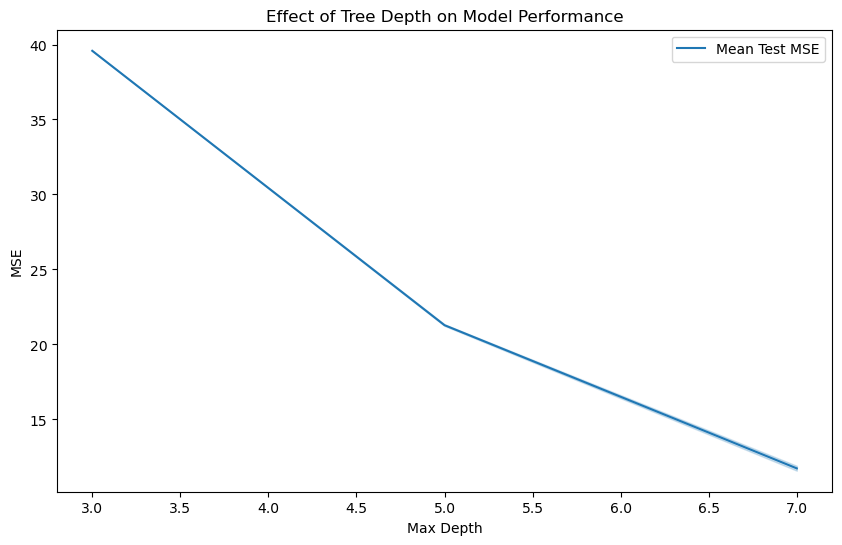

In [36]:
# Update the hyperparameter grid to include smaller depths, and larger sample splits/leaves
param_grid = {
    'max_depth': [3, 5, 7],  # Limit the tree depth
    'min_samples_split': [10, 20, 30],  # Increase the minimum samples required to split
    'min_samples_leaf': [5, 10, 15],  # Increase the minimum samples per leaf
    'ccp_alpha': [0.001, 0.01, 0.1]  # Add pruning (cost complexity pruning)
}

# Initialize Decision Tree Regressor
dtr = DecisionTreeRegressor()

# Perform Grid Search with cross-validation, including pruning
grid_search = GridSearchCV(dtr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model after hyperparameter tuning
best_tree = grid_search.best_estimator_

# Print best parameters
print(f"Best hyperparameters for Decision Tree: {grid_search.best_params_}")

# Predicting on training and test sets
y_train_pred_tree = best_tree.predict(X_train_scaled)
y_test_pred_tree = best_tree.predict(X_test_scaled)

# Evaluate performance
train_mse_tree, train_rmse_tree, train_r2_tree = evaluate_model(y_train, y_train_pred_tree)
test_mse_tree, test_rmse_tree, test_r2_tree = evaluate_model(y_test, y_test_pred_tree)

# Print training metrics
print("Decision Tree Regression Model - Training Metrics:")
print(f"MSE: {train_mse_tree:.4f}, RMSE: {train_rmse_tree:.4f}, R²: {train_r2_tree:.4f}")

# Print test metrics
print("\nDecision Tree Regression Model - Test Metrics:")
print(f"MSE: {test_mse_tree:.4f}, RMSE: {test_rmse_tree:.4f}, R²: {test_r2_tree:.4f}")

# Comparing multiple hyperparameter settings
results = pd.DataFrame(grid_search.cv_results_)

# Plotting RMSE vs hyperparameters
plt.figure(figsize=(10, 6))
sns.lineplot(x=results['param_max_depth'], y=-results['mean_test_score'], label='Mean Test MSE')
plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('Effect of Tree Depth on Model Performance')
plt.legend()
plt.show()
